In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from encoder import *
from plot_fns import *
from utils_data import *
from utils_train import *

set_plt_settings()
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
# Remote instance set-up cell
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cpu


## Make data

## Fake data

In [74]:
# make data
N = 1000
L = 400
n_nodes = 8
n_series = 3
latent_dim = 25

X = make_fake_data(N, L, n_nodes, n_series)
X = torch.tensor(X, dtype=torch.float)

100%|███████████████████████████████████████| 399/399 [00:00<00:00, 5810.50it/s]


Returning dataset with shape:	 (1000, 8, 400, 3)


## Real data

In [75]:
X_raw = np.load('../data/combined_array_data.npy')

In [76]:
X_32 = X_raw.astype(np.float32)

In [77]:
X_T = X_32.transpose(3,1,0,2)
X = torch.tensor(X_T)

KeyboardInterrupt: 

In [ ]:
MEAN = X.mean(axis=(0, 2, 3))
STD = X.std(axis=(0, 2, 3))

In [ ]:
# normalize
X = X.sub_(MEAN[None, :, None, None]).div_(STD[None, :, None, None])

In [ ]:
X.shape

## train model

In [ ]:
latent_dim = 100
N, n_nodes, L, n_series = X.shape

In [ ]:
encode = Encoder(latent_dim=latent_dim, dims=(n_nodes, L, n_series))

In [ ]:
dataloaders, ds_sizes = make_dataloaders(X, None, batch_size=32)
lr = 5e-3
model = VAE(Encoder, Decoder, latent_dim, (n_nodes, L, n_series))
criterion = vae_loss
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
dataset_sizes = ds_sizes

wts, loss_summ = train_model(model, criterion, optimizer, None, dataloaders, ds_sizes, PATH_MODELS, device, 12)

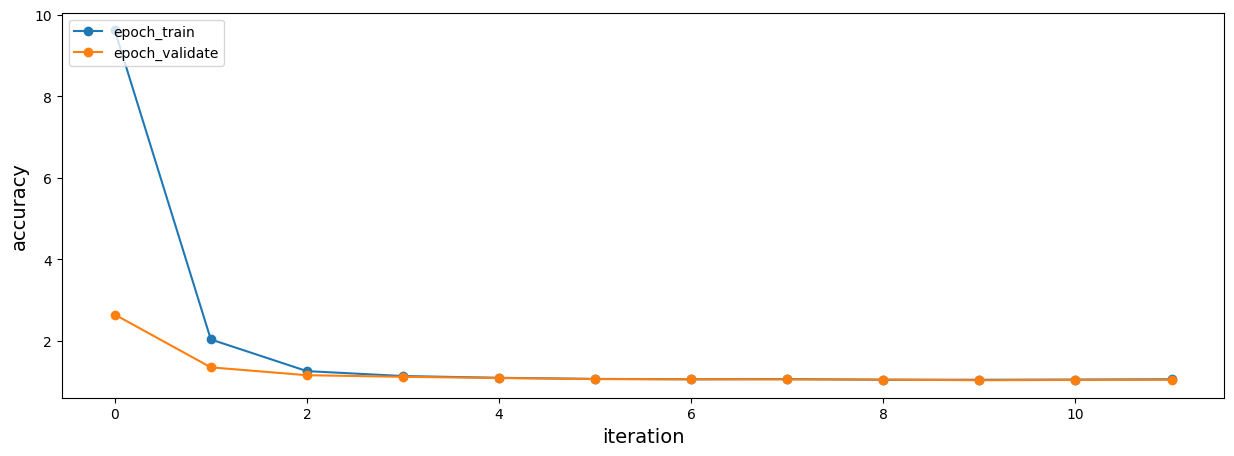

In [57]:
plot_accs({key: loss_summ[key] for key in ['epoch_train', 'epoch_validate']})

In [55]:
model_name = 'testcase'
save_mode = False
# save to file
if save_mode:
    # MODEL
    torch.save(model.state_dict(), PATH_MODELS + f'{model_name}.pt')
    # RESULTS
    filename = f'loss_{model_name}.csv'
    epoch_results = pd.DataFrame({key: torch.Tensor(loss_summ[key]) for key in ['epoch_train', 'epoch_validate']})
    epoch_results.to_csv(PATH_RESULTS + filename)

## Test model

In [63]:
x = X[:32]
model.load_state_dict(wts)
xhat, mu, logvar = model(x)

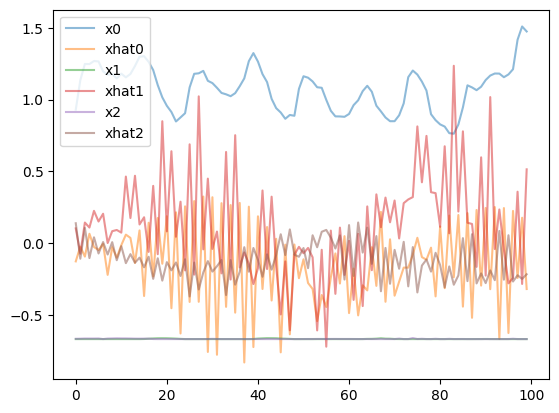

In [70]:
ran = list(range(0, 100))
k = 1
i = 5
j = 1
for j in range(3):
    plt.plot(x[k, i, ran, j], alpha=0.5, label=f'x{j}')
    plt.plot(xhat[k, i, ran, j].detach(), alpha=0.5, label=f'xhat{j}')

plt.legend()
plt.show()